In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn
from scipy import stats
from scipy.stats import norm, skew
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load Data

In [177]:
"""!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission
!pip install --upgrade --force-reinstall -- kaggle
!kaggle competitions download -c datacept-wine-prices-prediction -p /content/
import os
os.chdir('../content/')  #change dir"""


"!pip install -q kaggle\n!mkdir -p ~/.kaggle\n!cp kaggle.json ~/.kaggle/\n!ls ~/.kaggle\n!chmod 600 /root/.kaggle/kaggle.json  # set permission\n!pip install --upgrade --force-reinstall -- kaggle\n!kaggle competitions download -c datacept-wine-prices-prediction -p /content/\nimport os\nos.chdir('../content/')  #change dir"

In [0]:
#!unzip -q /content/datacept-wine-prices-prediction.zip   #unzip data in train/

In [0]:
train = pd.read_csv("../content/trainfinal.csv")
test = pd.read_csv("../content/test.csv")
sub = pd.read_csv("../content/Sample_sub.csv")


In [180]:
train.shape

(131250, 14)

In [181]:
test.shape

(40686, 13)

# Cleaning

In [182]:
before = len(train)
Q1 = train['price'].quantile(0.25)
Q3 = train['price'].quantile(0.75)
IQR = Q3 - Q1
# define outliers and remove them
filter_ = (train['price'] > Q1 - 1.5 * IQR) & (train['price'] < Q3 + 1.5 *IQR)
train = train[filter_]

after = len(train)
diff = before-after
percent = diff/before*100
print('{} ({:.2f}%) outliers removed'.format(diff, percent))

7751 (5.91%) outliers removed


In [0]:
train = train[train.country.isna() == False]
train = train[train.variety.isna() == False]
test.loc[test.country.isna() == True, 'country'] = 'US'
test.loc[test.province.isna() == True, 'province'] = 'California'

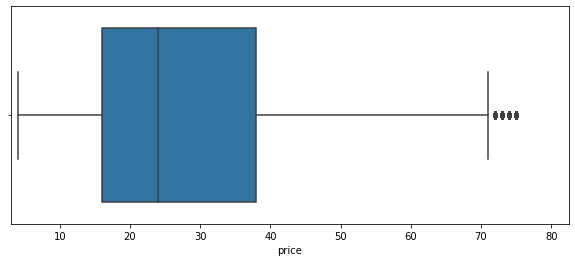

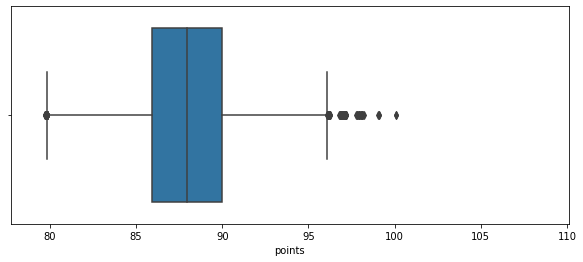

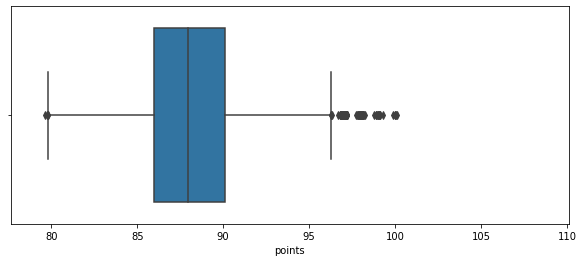

In [184]:
plt.figure(figsize=(10,4))
plt.xlim(train.price.min()-1, train.price.max()*1.1)
sns.boxplot(x=train.price)

plt.figure(figsize=(10,4))
plt.xlim(train.points.min()-2, train.points.max()*1.1)
sns.boxplot(x=train.points)

plt.figure(figsize=(10,4))
plt.xlim(test.points.min()-2, test.points.max()*1.1)
sns.boxplot(x=test.points)

In [0]:
y     = train[['id','price']]
y_t = test.id
train = train.drop(['id','price'],axis=1)
test = test.drop('id',axis=1)
all_dfs = [train,test]
train = pd.concat(all_dfs).reset_index(drop=True);

In [186]:
#missing data
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(15)

,Total,Percent
taster_twitter_handle,106089,0.646332
taster_name,102896,0.626879
region_2,92750,0.565066
title,87369,0.532283
designation,50029,0.304795
region_1,27259,0.166072
winery,0,0.000000
variety,0,0.000000
province,0,0.000000
points,0,0.000000


In [0]:
train.drop(['title','region_2','taster_name','taster_twitter_handle'], axis=1, inplace=True)

In [0]:
train['designation'].fillna("Reserve",inplace=True)
train['region_1'].fillna('Napa Valley',inplace=True)

In [189]:
train.head()

,country,description,designation,points,province,region_1,variety,winery
0,US,"From organic grapes, this fresh, slightly swee...",Areté Vineyards Dry,86.981265,Washington,Columbia Valley (WA),CHENIN BLANC,Tagaris
1,Italy,This 100% Cortese wine has a slight fizz and a...,Reserve,87.049806,Piedmont,Gavi,CORTESE,Principessa Gavia
2,Italy,This is rather shy on the nose while the racy ...,Reserve,84.978262,Tuscany,Vernaccia di San Gimignano,VERNACCIA,Tenuta La Vigna
3,US,"Full-bodied, high in alcohol and very rich in ...",Reserve,89.145719,California,Dry Creek Valley,CABERNET SAUVIGNON,Adobe Road
4,Italy,Here's a pretty Pinot Grigio with broad aromas...,Reserve,85.127045,Veneto,Piave,PINOT GRIGIO,Moletto


In [0]:
ntrain=len(y['price'])
new_train= train.iloc[:ntrain, :]
new_test = train.iloc[ntrain:, :]

# NLP Approach

In [191]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
from nltk import FreqDist, word_tokenize
from wordcloud import STOPWORDS
stopwords = set(STOPWORDS)
from sklearn.feature_extraction.text import TfidfVectorizer

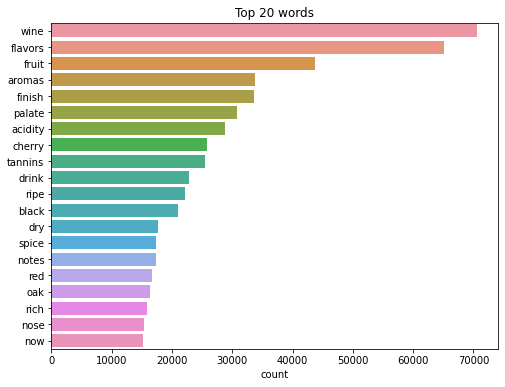

In [193]:
word_freq = FreqDist(w for w in word_tokenize(' '.join(new_train['description']).lower()) if 
                     (w not in stopwords) & (w.isalpha()))
df_word_freq = pd.DataFrame.from_dict(word_freq, orient='index', columns=['count'])
top20w = df_word_freq.sort_values('count',ascending=False).head(20)

plt.figure(figsize=(8,6))
sns.barplot(top20w['count'], top20w.index)
plt.title('Top 20 words')
plt.show()

In [194]:
from sklearn.feature_extraction.text import TfidfVectorizer

vec_text = TfidfVectorizer(min_df = 40000, ngram_range = (1,2), stop_words='english') 

# Have unigrams and bigrams
text_vec = vec_text.fit_transform(new_train['description'])
text_vec_test = vec_text.transform(new_test['description'])
X_train_text = pd.DataFrame(text_vec.toarray(), columns=vec_text.get_feature_names())
X_test_text = pd.DataFrame(text_vec_test.toarray(), columns=vec_text.get_feature_names())
print (X_train_text.shape)

(123454, 3)


In [195]:
X_train_text.head()

,flavors,fruit,wine
0,1.000000,0.0,0.000000
1,0.695023,0.0,0.718988
2,0.000000,1.0,0.000000
3,0.000000,0.0,0.000000
4,0.000000,0.0,1.000000


In [0]:
new_test=new_test.reset_index(False)
new_test=new_test.drop('index',1)
new_train = new_train.join(X_train_text, rsuffix='_text')
new_test = new_test.join(X_test_text, rsuffix='_text')
new_train=new_train.drop('description',1)
new_test=new_test.drop('description',1)

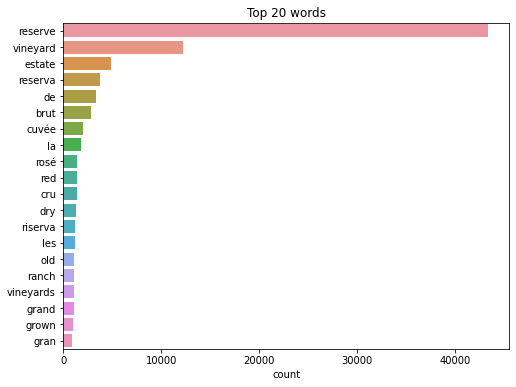

In [197]:
word_freq = FreqDist(w for w in word_tokenize(' '.join(new_train['designation'].astype(str)).lower()) if 
                     (w not in stopwords) & (w.isalpha()))
df_word_freq = pd.DataFrame.from_dict(word_freq, orient='index', columns=['count'])
top20w = df_word_freq.sort_values('count',ascending=False).head(20)

plt.figure(figsize=(8,6))
sns.barplot(top20w['count'], top20w.index)
plt.title('Top 20 words')
plt.show()

In [198]:
vec_text = TfidfVectorizer(min_df = 5000, ngram_range = (1,2), stop_words='english') 
# Only include >=10 occurrences
# Have unigrams and bigrams
text_vec = vec_text.fit_transform(new_train['designation'])
text_vec_test = vec_text.transform(new_test['designation'])
X_train_text = pd.DataFrame(text_vec.toarray(), columns=vec_text.get_feature_names())
X_test_text = pd.DataFrame(text_vec_test.toarray(), columns=vec_text.get_feature_names())
print (X_train_text.shape)

(123454, 2)


In [0]:
new_train = new_train.join(X_train_text, rsuffix='_text')
new_test = new_test.join(X_test_text, rsuffix='_text')
new_train=new_train.drop('designation',1)
new_test=new_test.drop('designation',1)

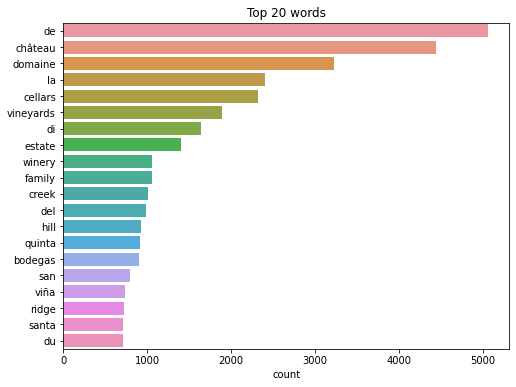

In [200]:
word_freq = FreqDist(w for w in word_tokenize(' '.join(new_train['winery'].astype(str)).lower()) if 
                     (w not in stopwords) & (w.isalpha()))
df_word_freq = pd.DataFrame.from_dict(word_freq, orient='index', columns=['count'])
top20w = df_word_freq.sort_values('count',ascending=False).head(20)

plt.figure(figsize=(8,6))
sns.barplot(top20w['count'], top20w.index)
plt.title('Top 20 words')
plt.show()

In [201]:
vec_text = TfidfVectorizer(min_df = 2000, ngram_range = (1,2), stop_words='english') 
text_vec = vec_text.fit_transform(new_train['winery'])
text_vec_test = vec_text.transform(new_test['winery'])
X_train_text = pd.DataFrame(text_vec.toarray(), columns=vec_text.get_feature_names())
X_test_text = pd.DataFrame(text_vec_test.toarray(), columns=vec_text.get_feature_names())
print (X_train_text.shape)

(123454, 4)


In [0]:
new_train = new_train.join(X_train_text, rsuffix='_text')
new_test = new_test.join(X_test_text, rsuffix='_text')
new_train=new_train.drop('winery',1)
new_test=new_test.drop('winery',1)

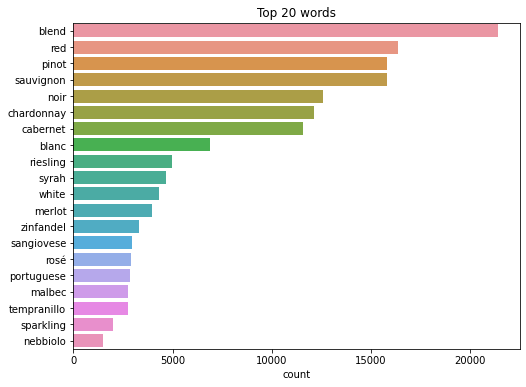

In [203]:
word_freq = FreqDist(w for w in word_tokenize(' '.join(new_train['variety'].astype(str)).lower()) if 
                     (w not in stopwords) & (w.isalpha()))
df_word_freq = pd.DataFrame.from_dict(word_freq, orient='index', columns=['count'])
top20w = df_word_freq.sort_values('count',ascending=False).head(20)

plt.figure(figsize=(8,6))
sns.barplot(top20w['count'], top20w.index)
plt.title('Top 20 words')
plt.show()

In [204]:
vec_text = TfidfVectorizer(min_df = 15000, ngram_range = (1,2), stop_words='english') 
text_vec = vec_text.fit_transform(new_train['variety'])
text_vec_test = vec_text.transform(new_test['variety'])
X_train_text = pd.DataFrame(text_vec.toarray(), columns=vec_text.get_feature_names())
X_test_text = pd.DataFrame(text_vec_test.toarray(), columns=vec_text.get_feature_names())
print (X_train_text.shape)

(123454, 4)


In [0]:
new_train = new_train.join(X_train_text, rsuffix='_text')
new_test = new_test.join(X_test_text, rsuffix='_text')
new_train=new_train.drop('variety',1)
new_test=new_test.drop('variety',1)

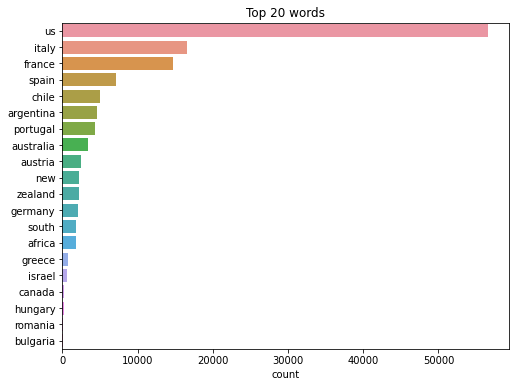

In [206]:
word_freq = FreqDist(w for w in word_tokenize(' '.join(new_train['country'].astype(str)).lower()) if 
                     (w not in stopwords) & (w.isalpha()))
df_word_freq = pd.DataFrame.from_dict(word_freq, orient='index', columns=['count'])
top20w = df_word_freq.sort_values('count',ascending=False).head(20)

plt.figure(figsize=(8,6))
sns.barplot(top20w['count'], top20w.index)
plt.title('Top 20 words')
plt.show()

In [207]:
vec_text = TfidfVectorizer(min_df = 2000, ngram_range = (1,2), stop_words='english') 
text_vec = vec_text.fit_transform(new_train['country'])
text_vec_test = vec_text.transform(new_test['country'])
X_train_text = pd.DataFrame(text_vec.toarray(), columns=vec_text.get_feature_names())
X_test_text = pd.DataFrame(text_vec_test.toarray(), columns=vec_text.get_feature_names())
print (X_train_text.shape)

(123454, 12)


In [0]:
new_train = new_train.join(X_train_text, rsuffix='_text')
new_test = new_test.join(X_test_text, rsuffix='_text')
new_train=new_train.drop('country',1)
new_test=new_test.drop('country',1)

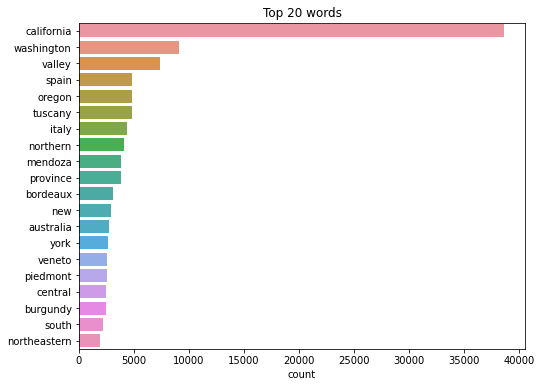

In [209]:
word_freq = FreqDist(w for w in word_tokenize(' '.join(new_train['province'].astype(str)).lower()) if 
                     (w not in stopwords) & (w.isalpha()))
df_word_freq = pd.DataFrame.from_dict(word_freq, orient='index', columns=['count'])
top20w = df_word_freq.sort_values('count',ascending=False).head(20)

plt.figure(figsize=(8,6))
sns.barplot(top20w['count'], top20w.index)
plt.title('Top 20 words')
plt.show()

In [210]:
vec_text = TfidfVectorizer(min_df = 5000, ngram_range = (1,2), stop_words='english') 
text_vec = vec_text.fit_transform(new_train['province'])
text_vec_test = vec_text.transform(new_test['province'])
X_train_text = pd.DataFrame(text_vec.toarray(), columns=vec_text.get_feature_names())
X_test_text = pd.DataFrame(text_vec_test.toarray(), columns=vec_text.get_feature_names())
print (X_train_text.shape)

(123454, 3)


In [0]:
new_train = new_train.join(X_train_text, rsuffix='_text')
new_test = new_test.join(X_test_text, rsuffix='_text')
new_train=new_train.drop('province',1)
new_test=new_test.drop('province',1)

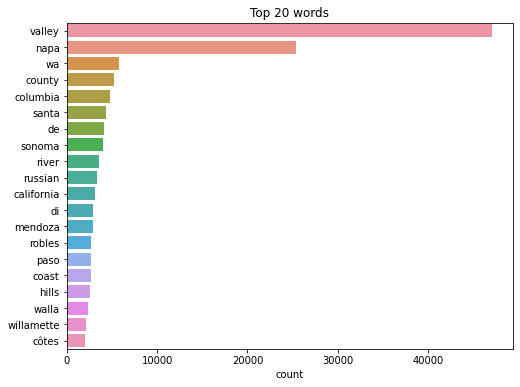

In [212]:
word_freq = FreqDist(w for w in word_tokenize(' '.join(new_train['region_1'].astype(str)).lower()) if 
                     (w not in stopwords) & (w.isalpha()))
df_word_freq = pd.DataFrame.from_dict(word_freq, orient='index', columns=['count'])
top20w = df_word_freq.sort_values('count',ascending=False).head(20)

plt.figure(figsize=(8,6))
sns.barplot(top20w['count'], top20w.index)
plt.title('Top 20 words')
plt.show()

In [213]:
vec_text = TfidfVectorizer(min_df = 5000, ngram_range = (1,2), stop_words='english') 
text_vec = vec_text.fit_transform(new_train['region_1'])
text_vec_test = vec_text.transform(new_test['region_1'])
X_train_text = pd.DataFrame(text_vec.toarray(), columns=vec_text.get_feature_names())
X_test_text = pd.DataFrame(text_vec_test.toarray(), columns=vec_text.get_feature_names())
print (X_train_text.shape)

(123454, 6)


In [0]:
new_train = new_train.join(X_train_text, rsuffix='_text')
new_test = new_test.join(X_test_text, rsuffix='_text')
new_train=new_train.drop('region_1',1)
new_test=new_test.drop('region_1',1)

# Traning/Evaluating

In [0]:
Scaler = StandardScaler()
train_scaled = pd.DataFrame(Scaler.fit_transform(new_train))
test_scaled = pd.DataFrame(Scaler.fit_transform(new_test))

In [216]:
train_scaled.shape

(123454, 35)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(train_scaled, y['price'], test_size=0.1, random_state=42)

In [0]:
import tensorflow as tf
ann = tf.keras.models.Sequential()
ann.add(tf.keras.layers.Dense(units=528, activation='relu'))
ann.add(tf.keras.layers.Dropout(0.1))
ann.add(tf.keras.layers.Dense(units=528, activation='relu'))

ann.add(tf.keras.layers.Dense(units=1))


In [0]:
ann.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [236]:
ann.fit(X_train, y_train,validation_data=(X_test,y_test), batch_size = 100, epochs = 10)

Epoch 1/10

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

1112/1112 [==============================] - 3s 2ms/step - loss: 155.8639 - val_loss: 146.0406
Epoch 2/10
1112/1112 [==============================] - 2s 2ms/step - loss: 141.9840 - val_loss: 145.4856
Epoch 3/10
1112/1112 [==============================] - 2s 2ms/step - loss: 141.3302 - val_loss: 144.3570
Epoch 4/10
1112/1112 [==============================] - 2s 2ms/step - loss: 140.5534 - val_loss: 142.3236
Epoch 5/10
1112/1112 [==============================] - 2s 2ms/step - loss: 140.0818

In [0]:
y_pred = ann.predict(test_scaled)

In [0]:
y_pred0=pd.DataFrame()
y_pred0['id'] = y_t
y_pred0['price'] = y_pred
y_pred0.to_csv('Sub.csv',index=False)

In [239]:
y_pred

array([[32.55509 ],
       [30.520912],
       [32.243084],
       ...,
       [23.800291],
       [18.608421],
       [15.539717]], dtype=float32)